# Assignment 2: Training the Fully Recurrent Network

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.


## Exercise 1: Data generation

There are two classes, both occurring with probability 0.5. There is one input unit. Only the first sequence element conveys relevant information about the class. Sequence elements at positions $t > 1$ stem from a Gaussian with mean zero and variance 0.2. The first sequence element is 1.0 (-1.0) for class 1 (2). Target at sequence end is 1.0 (0.0) for class 1 (2)

Write a function `generate_data` that takes an integer `T` as argument which represents the sequence length. Seed the `numpy` random generator with the number `0xDEADBEEF`. Implement the [Python3 generator](https://docs.python.org/3/glossary.html#term-generator) pattern and produce data in the way described above. The input sequences should have the shape `(T, 1)` and the target values should have the shape `(1,)`.

In [4]:
%matplotlib inline
import numpy as np
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

class FullyRecurrentNetwork(object):
    def __init__(self, D, I, K):
        self.D = D
        self.I = I
        self.K = K
        self.W = np.random.uniform(-0.01, 0.01, (I, D))
        self.R = np.random.uniform(-0.01, 0.01, (I, I))
        self.V = np.random.uniform(-0.01, 0.01, (K, I))
    
    def forward(self, x, y):
        # helper function for numerically stable loss
        def f(z):
            return np.log1p(np.exp(-np.absolute(z))) + np.maximum(0, z)
        
        # infer dims
        T, D = x.shape
        K, I = self.V.shape

        # init result arrays
        self.x = x
        self.y = y
        self.a = np.zeros((T, I))
        self.T = T

        # iterate forward in time 
        # trick: access model.a[-1] in first iteration
        for t in range(T):
            self.a[t] = np.tanh(self.W @ x[t] + self.R @ self.a[t-1])
            
        self.z = self.V @ self.a[t]
        return y * f(-self.z) + (1-y) * f(self.z)

T, D, I, K = 10, 3, 5, 1
model = FullyRecurrentNetwork(D, I, K)
model.forward(np.random.uniform(-1, 1, (T, D)), 1)

def generate_data(T, D=1):
    ########## YOUR SOLUTION HERE ##########
    # Including also D for next implementation
    np.random.seed(0xDEADBEEF)
    while True:
        # Choose a class with probability 0.5
        cls = np.random.choice([1, 2])
        # Generate the first sequence element based on the class
        first_element = 1.0 if cls == 1 else -1.0
        # Generate the remaining sequence elements from a Gaussian distribution
        remaining_elements = np.random.normal(loc=0.0, scale=np.sqrt(0.2), size=(T-1, D))
        # Combine the first element and the remaining elements
        sequence = np.vstack(([first_element] * D, remaining_elements)).reshape(T, D)
        # Set the target value based on the class
        target = np.array([1.0 if cls == 1 else 0.0])
        yield sequence, target

data = generate_data(2)

## Exercise 2: Gradients for the network parameters
Compute gradients of the total loss 
$$
L = \sum_{t=1}^T L(t), \quad \text{where} \quad L(t) = L(z(t), y(t))
$$
w.r.t. the weights of the fully recurrent network. To this end, find the derivative of the loss w.r.t. the logits and hidden pre-activations first, i.e., 
$$
\psi^\top(t) = \frac{\partial L}{\partial z(t)} \quad \text{and} \quad \delta^\top(t) = \frac{\partial L}{\partial s(t)}.
$$
With the help of these intermediate results you should be able to compute the gradients w.r.t. the weights, i.e., $\nabla_W L, \nabla_R L, \nabla_V L$. 

*Hint: Take a look at the computational graph from the previous assignment to see the functional dependencies.*

*Remark: Although we only have one label at the end of the sequence, we consider the more general case of evaluating a loss at every time step in this exercise (many-to-many mapping).*

########## YOUR SOLUTION HERE ##########

To evaluate the loss gradient wrt network weights, the derivates of the loss wrt the logit $z$ and hidden pre-activation have to be calculated. These intermediates calculations will allow to evaluate the gradient wrt to $W$, $R$ and $V$. 
The total loss is defined as the sum of the loss of each element of the sequence, where $L(t)$ is the lost of the $t-th$ element. 
$$L = \sum_{t=1}^T L(t)$$
The loss of each element is defined as:
$$L(z, y) = -y \log(\sigma(z)) - (1-y) \log(1 - \sigma(z))$$
Where $\sigma(z)$ is the sigmoid function. The derivative wrt to $z(t)$ is therefore: 
$$\frac{\partial L}{\partial z} = \sigma(z) – y$$
This value will be used as $(\psi^\top(t))$ to evaluate the gradients wrt to the weights.
The next step is to evaluate the gradient of the loss wrt hidden pre-activation: $(a(t))$, $(\delta^\top(t))$ using the chain rule: 
$$
\delta^\top(t) = \frac{\partial L}{\partial a(t)} = \frac{\partial L}{\partial z} \frac{\partial z}{\partial a(t)}
$$
Since $z = V a(T)$ we have:
$$\frac{\partial z}{\partial a(t)} = V^\top$$
so:
$$
\delta^\top(t) = (\sigma(z) - y) V^\top
$$
After evaluation the intermediate values, it is possible to use the chain rule to evaluate the gradients wrt to the weights. The gradient wrt to $W$ is:
$$
\nabla_W L = \frac{\partial L}{\partial W} = \sum_{t=1}^T \frac{\partial L}{\partial a(t)} \frac{\partial a(t)}{\partial W}
$$
Using the definition of $a(t)$:
$$
\frac{\partial a(t)}{\partial W} = \frac{\partial \tanh(W x(t) + R a(t-1))}{\partial W} = (1 - a(t)^2) x(t)^\top
$$

The gradient wrt to $W$ is then:
$$
\nabla_W L = \sum_{t=1}^T \delta^\top(t) (1 - a(t)^2) x(t)^\top
$$

Similarly to what have been done for $W$, the gradient wrt $R$ can be computed as:
$$
\nabla_R L = \frac{\partial L}{\partial R} = \sum_{t=1}^T \frac{\partial L}{\partial a(t)} \frac{\partial a(t)}{\partial R}
$$
Combining with the definition of $a(t)$:
$$
\frac{\partial a(t)}{\partial R} = \frac{\partial \tanh(W x(t) + R a(t-1))}{\partial R} = (1 - a(t)^2) a(t-1)^\top
$$
Which leads to:
$$
\nabla_R L = \sum_{t=1}^T \delta^\top(t) (1 - a(t)^2) a(t-1)^\top
$$
Finally the gradient wrt $V$ can be evaluated as:
$$
\nabla_V L = \frac{\partial L}{\partial V} = \frac{\partial L}{\partial z} \frac{\partial z}{\partial V} = (\sigma(z) - y) a(T)^\top
$$


## Exercise 3: The backward pass
Write a function `backward` that takes a model `self` as argument. The function should compute the gradients of the loss with respect to all model parameters and store them to `self.dW`, `self.dR`, `self.dV`, respectively. 

In [5]:
def backward(self):
    T, _ = self.a.shape
        
    # Calculate the derivative of the loss w.r.t. the logits z
    psi_top = sigmoid(self.z) - self.y
        
    # Initialize e the gradients
    dW = np.zeros_like(self.W, dtype=np.longdouble)
    dR = np.zeros_like(self.R, dtype=np.longdouble)
    dV = np.zeros_like(self.V, dtype=np.longdouble)
    
    # Initialize delta
    delta_t = np.zeros((T, self.I))  
    for t in range(T-1, -1, -1):
        if t == T-1:
            delta_t[t] = (psi_top @ self.V).T
        else:
            delta_t[t] = (delta_t[t+1] @ self.R) * (1 - self.a[t+1]**2)
        
        dW += np.outer(delta_t[t], self.x[t])
        if t > 0:
            dR += np.outer(delta_t[t], self.a[t-1])
    dV += psi_top * self.a[-1].T
        
    # Save the gradients in the attributes
    self.dW = dW
    self.dR = dR
    self.dV = dV


FullyRecurrentNetwork.backward = backward
model.backward()

## Exercise 4: Gradient checking
Write a function `grad_check` that takes a model `self`, a float `eps` and another float `thresh` as arguments and computes the numerical gradients of the model parameters according to the approximation
$$
f'(x) \approx \frac{f(x + \varepsilon) - f(x - \varepsilon)}{2 \varepsilon}.
$$
If any of the analytical gradients are farther than `thresh` away from the numerical gradients the function should throw an error. 

In [6]:
def grad_check(self, eps, thresh):
    ########## YOUR SOLUTION HERE ##########

    # function to compute the loss
    def loss(self):
        return np.sum(self.forward(self.x, self.y))

    # Compute analytical gradients
    self.backward()

    # Compute and check numerical gradient for W
    dW_num = np.zeros_like(self.W, dtype=np.longdouble)
    for i in range(self.W.shape[0]):
        for j in range(self.W.shape[1]):
            W_orig = self.W[i, j]
            
            self.W[i, j] = W_orig + eps
            loss_plus = loss(self)
            
            self.W[i, j] = W_orig - eps
            loss_minus = loss(self)
            
            dW_num[i, j] = (loss_plus - loss_minus) / (2 * eps)
            
            self.W[i, j] = W_orig  # reset parameter
    
    if not np.all(np.isclose(self.dW, dW_num, atol=thresh)):
        raise ValueError("Gradient check failed for W")
    # norm(a-b)/(norm(a)+norm(b)) < thresh
    # abs(a-b)

    # Compute and check numerical gradient for R
    dR_num = np.zeros_like(self.R, dtype=np.longdouble)
    for i in range(self.R.shape[0]):
        for j in range(self.R.shape[1]):
            R_orig = self.R[i, j]
            
            self.R[i, j] = R_orig + eps
            loss_plus = loss(self)
            
            self.R[i, j] = R_orig - eps
            loss_minus = loss(self)
            
            dR_num[i, j] = (loss_plus - loss_minus) / (2 * eps)
            
            self.R[i, j] = R_orig  # reset parameter
    
    if not np.all(np.isclose(self.dR, dR_num, atol=thresh)):
        raise ValueError("Gradient check failed for R")

    # Compute and check numerical gradient for V
    dV_num = np.zeros_like(self.V, dtype=np.longdouble)
    for i in range(self.V.shape[0]):
        for j in range(self.V.shape[1]):
            V_orig = self.V[i, j]
            
            self.V[i, j] = V_orig + eps
            loss_plus = loss(self)
            
            self.V[i, j] = V_orig - eps
            loss_minus = loss(self)
            
            dV_num[i, j] = (loss_plus - loss_minus) / (2 * eps)
            
            self.V[i, j] = V_orig  # reset parameter
    
    if not np.all(np.isclose(self.dV, dV_num, atol=thresh)):
        raise ValueError("Gradient check failed for V")

FullyRecurrentNetwork.grad_check = grad_check
model.grad_check(1e-7, 1e-7)

## Exercise 5: Parameter update

Write a function `update` that takes a model `self` and a float argument `eta`, which represents the learning rate. The method should implement the gradient descent update rule $\theta \gets \theta - \eta \nabla_{\theta}L$ for all model parameters $\theta$.

In [7]:
def update(self, eta):
    ########## YOUR SOLUTION HERE ##########
    self.W -= eta * self.dW
    self.R -= eta * self.dR
    self.V -= eta * self.dV

FullyRecurrentNetwork.update = update
model.update(0.001)

## Exercise 6: Network training

Train the fully recurrent network with 32 hidden units. Start with input sequences of length one and tune the learning rate and the number of update steps. Then increase the sequence length by one and tune the hyperparameters again. What is the maximal sequence length for which the fully recurrent network can achieve a performance that is better than random? Visualize your results. 

Best learning rate for T=1: 0.01, Accuracy: 1.0
Best learning rate for T=2: 0.01, Accuracy: 1.0
Best learning rate for T=3: 0.001, Accuracy: 1.0
Best learning rate for T=4: 0.01, Accuracy: 1.0
Best learning rate for T=5: 0.01, Accuracy: 0
Best learning rate for T=6: 0.001, Accuracy: 1.0
Best learning rate for T=7: 0.01, Accuracy: 0
Best learning rate for T=8: 0.01, Accuracy: 1.0
Best learning rate for T=9: 0.01, Accuracy: 0
Best learning rate for T=10: 0.01, Accuracy: 1.0
Best learning rate for T=11: 0.01, Accuracy: 1.0
Best learning rate for T=12: 0.01, Accuracy: 1.0
Best learning rate for T=13: 0.01, Accuracy: 0
Best learning rate for T=14: 0.01, Accuracy: 1.0
Best learning rate for T=15: 0.01, Accuracy: 1.0
Best learning rate for T=16: 0.01, Accuracy: 0
Best learning rate for T=17: 0.01, Accuracy: 1.0
Best learning rate for T=18: 0.01, Accuracy: 1.0
Best learning rate for T=19: 0.01, Accuracy: 0


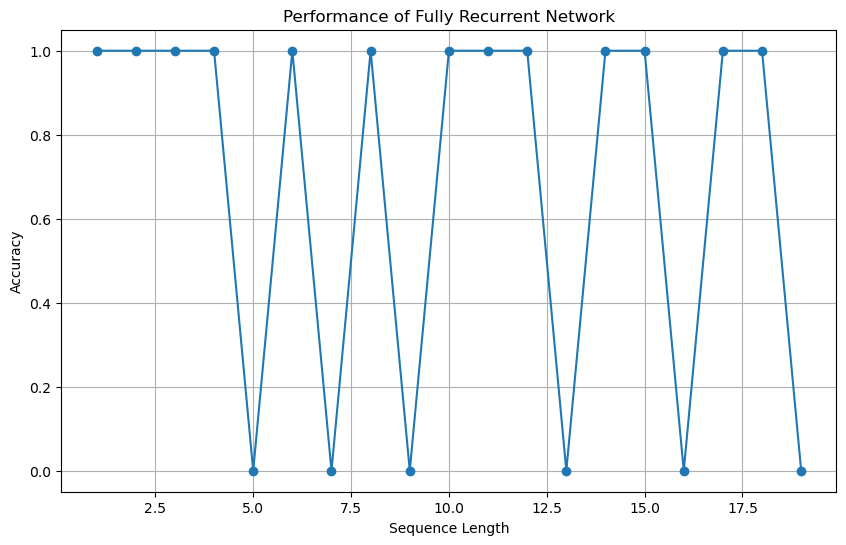

In [8]:
########## YOUR SOLUTION HERE ##########

def train_model(model, T, eta, num_updates, data_generator):
    for _ in range(num_updates):
        x, y = next(data_generator)
        if model.D == 1:
            x = np.broadcast_to(x, (model.D, 1)).T  # Broadcast the sequence to the desired shape
        else:
            x = x.reshape(T, model.D)  # Reshape x to have a shape of (T, model.D)
        _ = model.forward(x, y)
        model.backward()
        model.update(eta)
    return model

def evaluate_model(self, num_samples=100):
    correct_predictions = 0
    
    for _ in range(num_samples):
        x_test, y_test = next(generate_data(self.T, self.D))
        if self.T == 1:
            x_test = x_test.reshape(1, self.D)  # Reshape to (1, D)
        else:
            x_test = x_test.reshape(self.T, self.D)

        _ = self.forward(x_test, y_test)
        probability = sigmoid(self.z)
        prediction = 1 if probability > 0.5 else 0
        if prediction == y_test:
            correct_predictions += 1

    accuracy = correct_predictions / num_samples
    return accuracy


def visualize_results(T_values, results):
    accuracies = list(results.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(T_values, accuracies, marker='o')
    plt.xlabel('Sequence Length')
    plt.ylabel('Accuracy')
    plt.title('Performance of Fully Recurrent Network')
    plt.grid(True)
    plt.show()

FullyRecurrentNetwork.evaluate_model = evaluate_model

# Train and evaluate the model for different sequence lengths
results = {}
D, I, K = 3, 32, 1
learning_rates = [0.01, 0.001, 0.0001]  # Learning rate to tune
num_updates = 1000

T_values = list(range(1, 20))
for T in T_values:
    data_generator = generate_data(T, D)
    best_accuracy = 0
    best_lr = learning_rates[0]

    for lr in learning_rates:
        model_test = FullyRecurrentNetwork(D=D, I=I, K=K)
        model_test = train_model(model_test, T, lr, num_updates, data_generator)
        accuracy = model_test.evaluate_model()
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lr = lr
    
    results[T] = best_accuracy
    print(f"Best learning rate for T={T}: {best_lr}, Accuracy: {best_accuracy}")

visualize_results(T_values, results)


## Exercise 7: The Vanishing Gradient Problem

Analyze why the network is incapable of learning long-term dependencies. Show that $\|\frac{\partial a(T)}{\partial a(1)}\|_2 \leq \|R\|_2^{T-1}$ , where $\|\cdot\|_2$ is the spectral norm, and discuss how that affects the propagation of error signals through the time dimension of the network. 

*Hint: Use the fact that the spectral norm is submultiplicative for square matrices, i.e. $\|AB\|_2 \leq \|A\|_2\|B\|_2$ if $A$ and $B$ are both square.*

########## YOUR SOLUTION HERE ##########

The first step is to apply the chain rule to the LHS. It leads to:

$$
​\frac{\partial a(T)}{\partial a(1)} = \frac{\partial a(T)}{\partial a(T-1)} \cdot \frac{\partial a(T-1)}{\partial a(1)} = \frac{\partial a(T)}{\partial a(T-1)} \cdot \frac{\partial a(T-1)}{\partial a(T-2)} \cdot \frac{\partial a(T-2)}{\partial a(1)} =\prod_{t=2}^{T} \frac{\partial a(t)}{\partial a(t-1)}
$$

The hidden state at time $t$ can be expressed as a function of the hidden state at time $t-1$:

$$
a(t) = f(z(t)) = f(R a(t-1) + W x(t) + b)
$$

Applying again the chain rule can be obtained: 

$$
\frac{\partial a(t)}{\partial a(t-1)} = \frac{\partial f}{\partial z} \frac{\partial z}{\partial a(t-1)} = \frac{\partial f}{\partial z} \cdot R 
$$

Now,the submultiplicative property of the spectral norm to bound the norm of the product of derivatives can be used:

$$
\left\|\frac{\partial a(T)}{\partial a(1)}\right\|_2 = \left\|\prod_{t=2}^{T} R \frac{\partial f}{\partial z}\right\|_2
$$

$$
\leq \prod_{t=2}^{T} \left\|R \frac{\partial f}{\partial z}\right\|_2 
$$

$$
\leq \prod_{t=2}^{T} |R|_2 \left\|\frac{\partial f}{\partial z}\right\|_2 
$$

$$
\leq \|R\|_2^{T-1} \prod_{t=2}^{T} \left\|\frac{\partial f}{\partial z}\right\|_2 
$$

Since the activation function is always bound to 1

$$
\leq \|R\|_2^{T-1}
$$
This result shows that the norm of the derivative of the hidden state at time $T$ (called $a(T)) $with respect to the hidden state at time 1 (called $a(1)$) is bounded by the spectral norm of the recurrent weight matrix raised to the power of $T-1$.
When the spectral norm of $R$ is less than 1, the derivative norm will decrease exponentially with $T$, leading to the vanishing gradient problem. This means that the error signals that are propagated back through time will become smaller and smaller, making it difficult for the network to learn long-term dependencies.